In [7]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import NMF
from random import random
import matplotlib.pyplot as plt
import boruta

In [8]:
my_data=pd.read_csv('all_data_filtered.csv')
my_data.head(10)
my_data.index=my_data['Patient_id']
my_data=my_data.drop(['Patient_id'],axis=1)
y=my_data['MRD Response']
X=my_data.drop(['MRD Response'],axis=1)

### XGboost & shap values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=0)
XGBoost=GradientBoostingClassifier(n_estimators=100)
XGBoost=XGBoost.fit(X_train,y_train)

In [ ]:
y_pred=XGBoost.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
print('accuracy ',accuracy_score(y_pred=y_pred,y_true=y_test) )

accuracy  0.56


In [ ]:
import shap
#shap values
# Fits the explainer
explainer = shap.TreeExplainer(XGBoost)
# Evaluate SHAP values
shap_values = explainer.shap_values(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


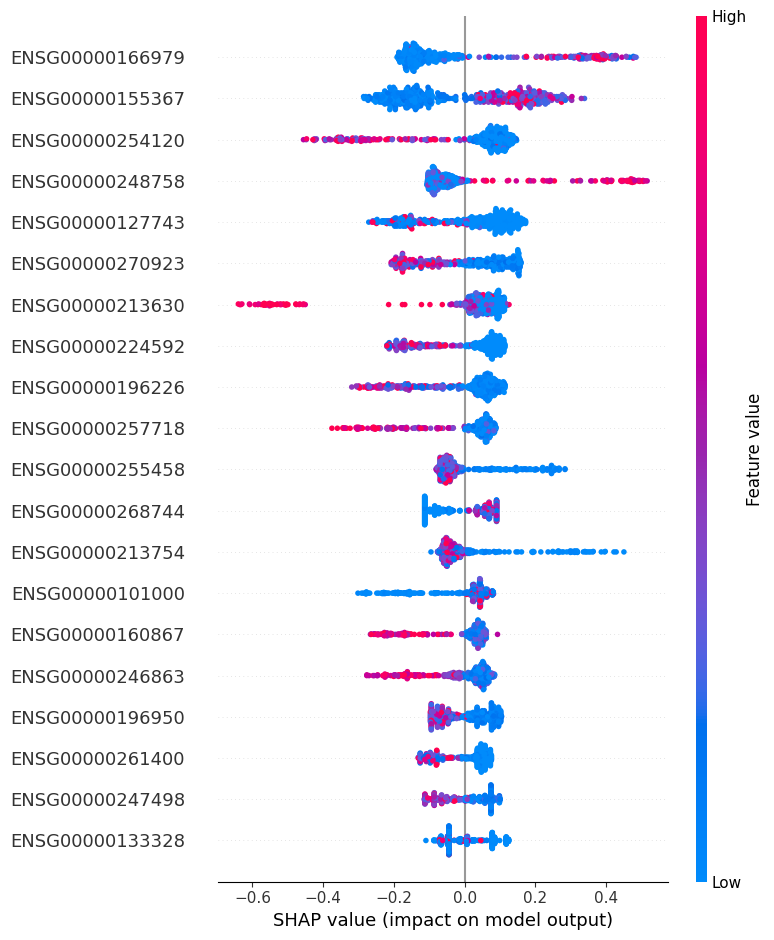

In [ ]:
shap.summary_plot(shap_values,X)

In [ ]:
feature_names=X.columns
top_n = 5
abs_shap_values = np.abs(shap_values.mean(axis=0))
top_n_idx = np.argsort(abs_shap_values)[-top_n:]
top_n_features = [feature_names[i] for i in top_n_idx]

print("Top %d features: %s" % (top_n, top_n_features))


Top 5 features: ['ENSG00000155367', 'ENSG00000269089', 'ENSG00000152133', 'ENSG00000206898', 'ENSG00000189091']


In [ ]:
top_n_features = [feature_names[i] for i in top_n_idx]

In [ ]:
top_n_features

['ENSG00000155367',
 'ENSG00000269089',
 'ENSG00000152133',
 'ENSG00000206898',
 'ENSG00000189091']